# Visualizing my job search process in 2023
1. Sankey flow of job applications to results
2. Tracking flow of applications, informational chats, and formal interviews
3. Effort focus on different job sectors
4. Cumulative job effort interactions in context of 2023

In [2]:
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

## 1. Job application results

In [3]:
#df = pd.read_csv('data/job_apps_2023_private.txt',sep='\t')
df = pd.read_csv('data/job_apps_2023.txt',sep='\t')
df


id                                title       app_response  \
0    1                        PhD Residency  Lost to the Abyss   
1    2           Computational Biologist II   Automated Reject   
2    3                               Intern  Lost to the Abyss   
3    4                  Data Science Intern  Lost to the Abyss   
4    5     PhD Residency - Planetary Health  Lost to the Abyss   
..  ..                                  ...                ...   
75  76      ML/AI Engineer - RNA/DNA Design  Interview Request   
76  77  Research Scientist - Sustainability  Lost to the Abyss   
77  78                     Bioinformatician  Interview Request   
78  79                       Data Scientist  Interview Request   
79  80                       Data Scientist   Automated Reject   

         interview     offer personal_contact  
0              NaN        No              Yes  
1              NaN        No              Yes  
2              NaN        No              Yes  
3              NaN        No              Yes  
4              NaN        No              Yes  
..             ...       ...              ...  
75        Job Talk       Yes              Yes  
76             NaN        No               No  
77  Initial Screen  Withdrew              Yes  
78             NaN  Withdrew               No  
79             NaN        No              Yes  

[80 rows x 6 columns]

In [4]:
# Collect counts of applications on edges between path nodes
counts = {}

In [5]:
# Job App --> Personal Contact counts
pc = df[df['personal_contact']=='Yes']
counts[("Job Applications","Personal Contact")] = pc.shape[0]

# Job App --> Cold Applied counts
cold = df[df['personal_contact']!='Yes']
counts[("Job Applications","Cold Applied")] = cold.shape[0]

counts

{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38}

In [6]:
# Personal contact value counts
pc_vc = pc['app_response'].value_counts()

# response counts for personal contact
for key in pc_vc.keys():
    counts[("Personal Contact",key)] = pc_vc[key]
    
# Cold applied value counts
cold_vc = cold['app_response'].value_counts()

# response counts for cold applies
for key in cold_vc.keys():
    counts[("Cold Applied",key)] = cold_vc[key]
    
counts

{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38,
 ('Personal Contact', 'Lost to the Abyss'): 22,
 ('Personal Contact', 'Interview Request'): 11,
 ('Personal Contact', 'Automated Reject'): 6,
 ('Personal Contact', 'Human Reject'): 3,
 ('Cold Applied', 'Lost to the Abyss'): 19,
 ('Cold Applied', 'Automated Reject'): 15,
 ('Cold Applied', 'Interview Request'): 4}

In [7]:
# interview request value counts
int_vc = df['interview'].value_counts()

# define the flow of which interview types fed into counts of the others
# eg Job Talks were always preceeded by an initial screen and meeting more team members
int_flow = {
    'Initial Screen':['Initial Screen','Meet Team','Job Talk'],
    'Meet Team':['Meet Team','Job Talk'],
    'Job Talk':['Job Talk'],
}

# sum the counts of interview types that are subsets of others
int_counts = {}
for y in int_flow:
    int_counts[y] = sum([int_vc[x] for x in int_flow[y]])

int_counts

{'Initial Screen': 12, 'Meet Team': 6, 'Job Talk': 3}

In [8]:
# group by application reponse and final offer result 
dfg = df.groupby(["app_response","offer"])

# group interview types by final offer result
intg = df.fillna('')[df['app_response']=='Interview Request'].groupby(['interview',"offer"])

# Count number of rejections to final offer results
for response, result in dfg.groups:
    if response != "Interview Request": # aka rejection of some sort
        c = dfg.get_group((response,result)).shape[0]
        counts[(response,result)] = c
        print(response, result, c)

# Count number of interview types to final offer results
for interview,result in intg.groups:
    c = intg.get_group((interview,result)).shape[0]
    # If an interview was requested, but we didn't proceed to a screen
    # (eg remote was a deal breaker, or request came after I accepted elswhere)
    if interview == '':
        counts[("Interview Request",result)] = c
    else:
        counts[(interview,result)] = c
    print(interview, result,c)

counts

Automated Reject No 21
Human Reject No 3
Lost to the Abyss No 41
 Withdrew 3
Initial Screen No 5
Initial Screen Withdrew 1
Job Talk No 1
Job Talk Yes 2
Meet Team No 3


{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38,
 ('Personal Contact', 'Lost to the Abyss'): 22,
 ('Personal Contact', 'Interview Request'): 11,
 ('Personal Contact', 'Automated Reject'): 6,
 ('Personal Contact', 'Human Reject'): 3,
 ('Cold Applied', 'Lost to the Abyss'): 19,
 ('Cold Applied', 'Automated Reject'): 15,
 ('Cold Applied', 'Interview Request'): 4,
 ('Automated Reject', 'No'): 21,
 ('Human Reject', 'No'): 3,
 ('Lost to the Abyss', 'No'): 41,
 ('Interview Request', 'Withdrew'): 3,
 ('Initial Screen', 'No'): 5,
 ('Initial Screen', 'Withdrew'): 1,
 ('Job Talk', 'No'): 1,
 ('Job Talk', 'Yes'): 2,
 ('Meet Team', 'No'): 3}

In [9]:
# manually set these counts based on the tree structure I have in my head
counts[("Interview Request","Initial Screen")] = int_counts['Initial Screen']
counts[("Initial Screen","Meet Team")] = int_counts['Meet Team']
counts[("Meet Team","Job Talk")] = int_counts['Job Talk']
counts

{('Job Applications', 'Personal Contact'): 42,
 ('Job Applications', 'Cold Applied'): 38,
 ('Personal Contact', 'Lost to the Abyss'): 22,
 ('Personal Contact', 'Interview Request'): 11,
 ('Personal Contact', 'Automated Reject'): 6,
 ('Personal Contact', 'Human Reject'): 3,
 ('Cold Applied', 'Lost to the Abyss'): 19,
 ('Cold Applied', 'Automated Reject'): 15,
 ('Cold Applied', 'Interview Request'): 4,
 ('Automated Reject', 'No'): 21,
 ('Human Reject', 'No'): 3,
 ('Lost to the Abyss', 'No'): 41,
 ('Interview Request', 'Withdrew'): 3,
 ('Initial Screen', 'No'): 5,
 ('Initial Screen', 'Withdrew'): 1,
 ('Job Talk', 'No'): 1,
 ('Job Talk', 'Yes'): 2,
 ('Meet Team', 'No'): 3,
 ('Interview Request', 'Initial Screen'): 12,
 ('Initial Screen', 'Meet Team'): 6,
 ('Meet Team', 'Job Talk'): 3}

In [10]:
# convert to pandas dataframe
sank_data = []
for (s,t) in counts:
    sank_data.append([s,t,counts[(s,t)]])

# establish order of nodes
node_sort = ['Job Applications','Personal Contact','Cold Applied',
             'Lost to the Abyss','Automated Reject','Human Reject','Interview Request',
             'Initial Screen','Meet Team','Job Talk',#Terminated
             'No','Yes','Withdrew']

# put into df for sankey charting
sdf = pd.DataFrame(sank_data,columns = ['source','target','count'])

# enforcing a sort order
sdf['node_sort1'] = pd.Categorical(sdf['source'], node_sort,ordered=True)
sdf['node_sort2'] = pd.Categorical(sdf['target'], node_sort)
sdf.sort_values(['node_sort1','node_sort2'],inplace=True)
sdf

source             target  count         node_sort1  \
0    Job Applications   Personal Contact     42   Job Applications   
1    Job Applications       Cold Applied     38   Job Applications   
2    Personal Contact  Lost to the Abyss     22   Personal Contact   
4    Personal Contact   Automated Reject      6   Personal Contact   
5    Personal Contact       Human Reject      3   Personal Contact   
3    Personal Contact  Interview Request     11   Personal Contact   
6        Cold Applied  Lost to the Abyss     19       Cold Applied   
7        Cold Applied   Automated Reject     15       Cold Applied   
8        Cold Applied  Interview Request      4       Cold Applied   
11  Lost to the Abyss                 No     41  Lost to the Abyss   
9    Automated Reject                 No     21   Automated Reject   
10       Human Reject                 No      3       Human Reject   
18  Interview Request     Initial Screen     12  Interview Request   
12  Interview Request           Withdrew      3  Interview Request   
19     Initial Screen          Meet Team      6     Initial Screen   
13     Initial Screen                 No      5     Initial Screen   
14     Initial Screen           Withdrew      1     Initial Screen   
20          Meet Team           Job Talk      3          Meet Team   
17          Meet Team                 No      3          Meet Team   
15           Job Talk                 No      1           Job Talk   
16           Job Talk                Yes      2           Job Talk   

           node_sort2  
0    Personal Contact  
1        Cold Applied  
2   Lost to the Abyss  
4    Automated Reject  
5        Human Reject  
3   Interview Request  
6   Lost to the Abyss  
7    Automated Reject  
8   Interview Request  
11                 No  
9                  No  
10                 No  
18     Initial Screen  
12           Withdrew  
19          Meet Team  
13                 No  
14           Withdrew  
20           Job Talk  
17                 No  
15                 No  
16                Yes

In [11]:
sdf[['source','target','count']].to_csv('data/sankey_data_w2.csv')

## Create Sankey viz in Plotly

In [12]:
# plotly version
import plotly.graph_objects as go

If plotly randomly stops rendering in the notebook, switch on `fig.show(renderer="browser")` then back to `fig.show(renderer="notebook")`

In [13]:
# test plot
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": ["A", "B", "C", "D", "E", "F"],
        "x": [0.2, 0.1, 0.5, 0.7, 0.3, 0.5],
        "y": [0.7, 0.5, 0.2, 0.4, 0.2, 0.3],
        'pad':10},  # 10 Pixels
    link = {
        "source": [0, 0, 1, 2, 5, 4, 3, 5],
        "target": [5, 3, 4, 3, 0, 2, 2, 3],
        "value": [1, 2, 1, 1, 1, 1, 1, 2]}))

fig.show(renderer='notebook')

In [14]:
# create mapping of node to index
node_idx = enumerate(node_sort)
node_map = dict([(y,x) for (x,y) in node_idx])
node_map

{'Job Applications': 0,
 'Personal Contact': 1,
 'Cold Applied': 2,
 'Lost to the Abyss': 3,
 'Automated Reject': 4,
 'Human Reject': 5,
 'Interview Request': 6,
 'Initial Screen': 7,
 'Meet Team': 8,
 'Job Talk': 9,
 'No': 10,
 'Yes': 11,
 'Withdrew': 12}

In [15]:
# create index column
sdf['source_idx'] = sdf['source'].apply(lambda x: node_map[x])
sdf['target_idx'] = sdf['target'].apply(lambda x: node_map[x])
sdf.head()

source             target  count        node_sort1  \
0  Job Applications   Personal Contact     42  Job Applications   
1  Job Applications       Cold Applied     38  Job Applications   
2  Personal Contact  Lost to the Abyss     22  Personal Contact   
4  Personal Contact   Automated Reject      6  Personal Contact   
5  Personal Contact       Human Reject      3  Personal Contact   

          node_sort2  source_idx  target_idx  
0   Personal Contact           0           1  
1       Cold Applied           0           2  
2  Lost to the Abyss           1           3  
4   Automated Reject           1           4  
5       Human Reject           1           5

In [16]:
# calculate total counts flowing out of each node
node_count_dict = dict(sdf.groupby('source').sum('count').reset_index()[['source','count']].values)

# final results that were never source nodes (targets only)
finals = ['Yes','No','Withdrew']
temp = sdf.groupby('target').sum('count').reset_index()[['target','count']]
temp = dict(temp[temp['target'].isin(finals)].values)

node_count_dict = node_count_dict | temp
node_count_dict

{'Automated Reject': 21,
 'Cold Applied': 38,
 'Human Reject': 3,
 'Initial Screen': 12,
 'Interview Request': 15,
 'Job Applications': 80,
 'Job Talk': 3,
 'Lost to the Abyss': 41,
 'Meet Team': 6,
 'Personal Contact': 42,
 'No': 74,
 'Withdrew': 4,
 'Yes': 2}

In [17]:
# create two text lines for small nodes
small_boxes = ["Human Reject", "Job Talk"]
node_labels = ['<br>'.join(x.split()) if x in small_boxes else x for x in node_sort ]

# add node count tag to the end
node_tags = [node_count_dict[x] for x in node_sort]
node_labels = [node_labels[i] + f' <b>{node_tags[i]}</b>' for i in range(len(node_labels))]

node_labels

['Job Applications <b>80</b>',
 'Personal Contact <b>42</b>',
 'Cold Applied <b>38</b>',
 'Lost to the Abyss <b>41</b>',
 'Automated Reject <b>21</b>',
 'Human<br>Reject <b>3</b>',
 'Interview Request <b>15</b>',
 'Initial Screen <b>12</b>',
 'Meet Team <b>6</b>',
 'Job<br>Talk <b>3</b>',
 'No <b>74</b>',
 'Yes <b>2</b>',
 'Withdrew <b>4</b>']

In [18]:
# assign my own node colors
# weird note: colors that start with #FF make the links full red... not sure why.
# switching them to #FE fixed this... *shrug*
node_color = dict(enumerate([
    '#fed67a',# 0 'Job Applications',
    '#858dfb',# 1 'Personal Contact',
    '#bc85fb',# 2 'Cold Applied',
    '#FEB57E',# 3 'Lost to the Abyss',
    '#fe87a9',# 4 'Automated Reject',
    '#feadfe',# 5 'Human Reject',
    '#51AFF5',# 6 'Interview Request',
    '#50dcf6',# 7 'Initial Screen',
    '#3ad7ac',# 8 'Meet Team',
    '#34B83D',# 9 'Job Talk',
    #'#BDBBBD',# 10 'Terminated',
    '#f27a67',# 11 'No',
    '#8FD63A',# 12 'Yes',
    '#adadad',# 13 'Unknown',
]))

from matplotlib.colors import to_rgba,to_hex

# needed to switch these to rgba because plotly wouldn't accept HEX with transparency?
link_color = [to_rgba(node_color[x]) for x in node_color]
link_color = dict(enumerate([f'rgba({r:.3f},{g:.3f},{b:.3f},0.5)'for r,g,b,a in link_color]))

link_color

{0: 'rgba(0.996,0.839,0.478,0.5)',
 1: 'rgba(0.522,0.553,0.984,0.5)',
 2: 'rgba(0.737,0.522,0.984,0.5)',
 3: 'rgba(0.996,0.710,0.494,0.5)',
 4: 'rgba(0.996,0.529,0.663,0.5)',
 5: 'rgba(0.996,0.678,0.996,0.5)',
 6: 'rgba(0.318,0.686,0.961,0.5)',
 7: 'rgba(0.314,0.863,0.965,0.5)',
 8: 'rgba(0.227,0.843,0.675,0.5)',
 9: 'rgba(0.204,0.722,0.239,0.5)',
 10: 'rgba(0.949,0.478,0.404,0.5)',
 11: 'rgba(0.561,0.839,0.227,0.5)',
 12: 'rgba(0.678,0.678,0.678,0.5)'}

In [19]:
sdf['source_color'] = sdf['source_idx'].apply(lambda x: link_color[x])
sdf['target_color'] = sdf['target_idx'].apply(lambda x: link_color[x])
sdf.head()

source             target  count        node_sort1  \
0  Job Applications   Personal Contact     42  Job Applications   
1  Job Applications       Cold Applied     38  Job Applications   
2  Personal Contact  Lost to the Abyss     22  Personal Contact   
4  Personal Contact   Automated Reject      6  Personal Contact   
5  Personal Contact       Human Reject      3  Personal Contact   

          node_sort2  source_idx  target_idx                 source_color  \
0   Personal Contact           0           1  rgba(0.996,0.839,0.478,0.5)   
1       Cold Applied           0           2  rgba(0.996,0.839,0.478,0.5)   
2  Lost to the Abyss           1           3  rgba(0.522,0.553,0.984,0.5)   
4   Automated Reject           1           4  rgba(0.522,0.553,0.984,0.5)   
5       Human Reject           1           5  rgba(0.522,0.553,0.984,0.5)   

                  target_color  
0  rgba(0.522,0.553,0.984,0.5)  
1  rgba(0.737,0.522,0.984,0.5)  
2  rgba(0.996,0.710,0.494,0.5)  
4  rgba(0.996,0.529,0.663,0.5)  
5  rgba(0.996,0.678,0.996,0.5)

In [21]:
fig = go.Figure(go.Sankey(
    #arrangement = "snap",
    node = {
        "label": node_labels,
        "color":[node_color[node_map[x]] for x in node_sort],
        'hovertemplate':'%{value:1f}<extra></extra>',
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk',
# 'No','Yes','Withdrew']

# I didn't like the auto layout view, so I moved them precisely where I liked them, 
        "x": [0.01, 
              0.1, 0.1, 
              0.2, 0.2, 0.2, 0.2,
              0.27, 
              0.35, 0.42, #0.38,
              0.5, 0.5, 0.5,],
        "y": [0.75, 
              0.35, 1.2, 
              1.25, 0.65, 0.35, 0.1,
              0.20, 
              0.16, 0.11, #-0.01,
              0.95, 0.18, 0.001,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values,
        #'hovertemplate':'%{source.label} --> %{target.label}: <extra>%{value:1f}</extra>',
        'hovertemplate':'%{value:1f}<extra></extra>',
    },
    orientation = 'v',
    ),
    layout = go.Layout(
        autosize=True,
        width=800,
        height=600,
    )
)

fig.show()

In [22]:
fig.write_html('html/sankey_plot_final_static_w2.html')


In [23]:
# Different node placement?

fig = go.Figure(go.Sankey(
    #arrangement = "snap",
    node = {
        "label": node_labels,
        "color":[node_color[node_map[x]] for x in node_sort],
        'hovertemplate':'%{value:1f}<extra></extra>',
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk','Terminated',
# 'No','Yes','Unknown']

# I didn't like the auto layout view, so I moved them precisely where I liked them, 
        "x": [0.01, 
              0.1, 0.1, 
              0.2, 0.2, 0.2, 0.2,
              0.27, 
              0.34, 0.43, #0.34,
              0.5, 0.5, 0.5,],
        "y": [0.75, 
              0.35, 1.2, 
              1.25, 0.65, 0.35, 0.1,
              0.05, 
              0.001, 0.002, #0.23,
              0.95, 0.001, 0.13,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values,
        #'hovertemplate':'%{source.label} --> %{target.label}: <extra>%{value:1f}</extra>',
        'hovertemplate':'%{value:1f}<extra></extra>',
    },
    orientation = 'v',
    ),
    layout = go.Layout(
        autosize=True,
        width=800,
        height=600,
    )
)

fig.show()

In [24]:
#fig.write_html('html/sankey_plot_final_static.html')
#fig.write_json('sankey_plot.json')

## Tracking applications and career conversations over time

In [25]:
#cdf = pd.read_csv('data/convos_2023_private.txt',sep='\t')
cdf = pd.read_csv('data/convos_2023.txt',sep='\t')
cdf['Date'] = pd.to_datetime(cdf['Date'])

cdf.head()

Type       Date Sector Location  Job talk?  company_id
0     0 2022-09-15    BCD        E      False           0
1     0 2022-09-20     BD        M      False           1
2     0 2022-09-26     BD        M      False           1
3     0 2022-10-07     BD        M      False           2
4     0 2022-10-12     BD        Z      False           1

In [26]:
# consolidate sectors into broader groups to condense some plots later
broad_sector = {
    'B':'Biology',
    'BD':'Biology',
    'C':'Climate',
    'CD':'Climate',
    'BC':'Bio + Climate',
    'BCD':'Bio + Climate',
    'D':'Other (data)'
}

In [27]:
cdf['Sector2'] = cdf['Sector'].apply(lambda x: broad_sector[x])
cdf.head()

Type       Date Sector Location  Job talk?  company_id        Sector2
0     0 2022-09-15    BCD        E      False           0  Bio + Climate
1     0 2022-09-20     BD        M      False           1        Biology
2     0 2022-09-26     BD        M      False           1        Biology
3     0 2022-10-07     BD        M      False           2        Biology
4     0 2022-10-12     BD        Z      False           1        Biology

In [28]:
casual_df = cdf[cdf['Type']==0]
interview_df = cdf[cdf['Type']>0]
interview_df['Type'] = interview_df['Type'].astype(str)

interview_df.head()

/var/folders/z0/53b9pdsx1hg30nbh705jh_ym0000gn/T/ipykernel_20714/224404671.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Type       Date Sector Location  Job talk?  company_id        Sector2
31    1 2023-01-18     BD        Z      False          16        Biology
34    2 2023-01-31     BD        Z      False          16        Biology
36    3 2023-02-07     BD        Z      False          16        Biology
54    1 2023-04-04     CD        Z      False          33        Climate
64    1 2023-06-19     BC        Z      False          26  Bio + Climate

In [29]:
adf = pd.read_csv('data/job_apps_2023_timeline.txt',sep='\t')
adf['Date'] = pd.to_datetime(adf['Date'])
adf['Sector2'] = adf['Sector'].apply(lambda x: broad_sector[x])

adf.head()

Type       Date Sector  Seattle? Human contact  Interview stage Offer?  \
0    -1 2023-01-16     BD         0            No                0     No   
1    -1 2023-01-18     BD         1            No                0     No   
2    -1 2023-01-20     BD         0            No                0     No   
3    -1 2023-01-26      D         1            No                0     No   
4    -1 2023-01-31     CD         0            No                0     No   

        Sector2  
0       Biology  
1       Biology  
2       Biology  
3  Other (data)  
4       Climate

In [30]:
adf['Sector2'].value_counts()

Climate          30
Biology          25
Bio + Climate    16
Other (data)      9
Name: Sector2, dtype: int64

In [31]:
# offers
odf = pd.read_csv('data/offers.tsv',sep='\t')
odf['Date'] = pd.to_datetime(odf['Date'])
odf['Sector2'] = odf['Sector'].apply(lambda x: broad_sector[x])

odf

Date Sector   Real  Accept        Sector2
0 2023-08-11     CD  False   False        Climate
1 2023-11-09    BCD   True   False  Bio + Climate
2 2023-11-10    BCD   True    True  Bio + Climate

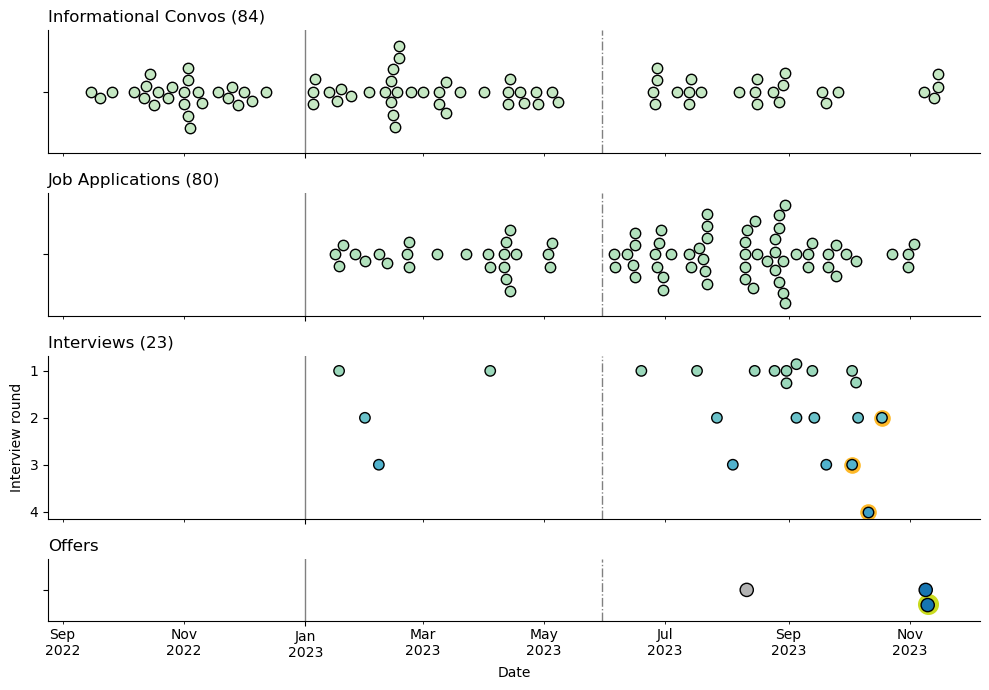

In [32]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(
    4,1,
    sharex=True,
    figsize=(10,7),
    gridspec_kw={'height_ratios': [1.5,1.5,2,0.75]}
)
msize=7.5
#sns.swarmplot(data=casual_df,x='Date',ax=ax1,size=8,hue="Sector",palette=colors,edgecolor='k',linewidth=1)
sns.swarmplot(data=casual_df,x='Date',ax=ax1,size=msize,color='#c5e8c3',edgecolor='k',linewidth=1)
sns.swarmplot(data=adf,x='Date',ax=ax2,size=msize,color='#b1e1bc',edgecolor='k',linewidth=1)
sns.swarmplot(data=interview_df,x='Date',y="Type",ax=ax3,size=msize,linewidth=1,edgecolor='k',
             hue="Type",palette={'1':'#9bd8bb','2':'#6ac2ca','3':'#51b2cd','4':'#3d9fc7'},
             legend=None)
sns.swarmplot(data=odf,x='Date',ax=ax4,size=msize+2,hue='Real',
              linewidth=1,edgecolor='k',palette={True:'#1675b1',False:'#b3b3b3'},legend=None)


locator = mdates.MonthLocator(bymonth=[3,5,7,9,11])
ax4.xaxis.set_minor_locator(locator)
#ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))
ax4.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax1.set_title(f"Informational Convos ({casual_df.shape[0]})",loc='left')
ax2.set_title(f"Job Applications ({adf.shape[0]})",loc='left')
ax3.set_title(f"Interviews ({interview_df.shape[0]})",loc='left')
ax3.set_ylabel("Interview round")
ax4.set_title(f"Offers",loc='left')

# mark defense and 2023
defense = pd.to_datetime('2023-05-30')
y2023 = pd.to_datetime('2023-01-01')
for ax in [ax1,ax2,ax3,ax4]:
    ax.axvline(defense,color='gray',linestyle='-.',linewidth=1)
    ax.axvline(y2023,color='gray',linewidth=1)
    
# highlight job talks
jts = interview_df[interview_df['Job talk?']==True]
ax3.scatter(jts['Date'],jts['Type'],color='#feb928',s=120,)

# highlight accept - finding the offset didn't work, just manually set it
acc = odf[odf['Accept']==True]
ax4.scatter(acc['Date'],-0.0047,color='#cadb20',s=200,) # #6abf50 #26bce1
ax4.set_ylim(-0.01,0.01)

    
sns.despine(left=False,bottom=False,top=True)
plt.tight_layout()
plt.savefig('img/convos_interviews.png',dpi=300)

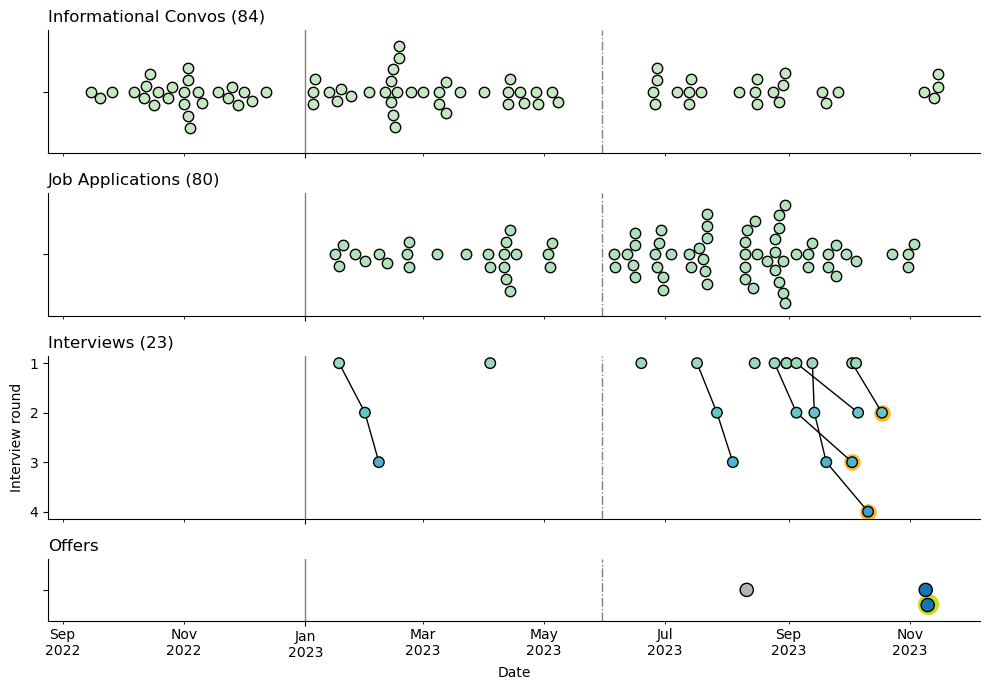

In [33]:
# Add interview connection lines

fig,(ax1,ax2,ax3,ax4) = plt.subplots(
    4,1,
    sharex=True,
    figsize=(10,7),
    gridspec_kw={'height_ratios': [1.5,1.5,2,0.75]}
)
msize=7.5
# info convos
sns.swarmplot(data=casual_df,x='Date',ax=ax1,size=msize,color='#c5e8c3',edgecolor='k',linewidth=1)

# job apps
sns.swarmplot(data=adf,x='Date',ax=ax2,size=msize,color='#b1e1bc',edgecolor='k',linewidth=1)

# interviews
for k,subdf in interview_df.groupby("company_id"):
    sns.lineplot(data=subdf,x='Date',y="Type",ax=ax3,
                 color='k',linewidth=1,legend=None)
sns.scatterplot(data=interview_df,x='Date',y="Type",ax=ax3,
                s=msize+50,linewidth=1,edgecolor='k',
                hue="Type",palette={'1':'#9bd8bb','2':'#6ac2ca','3':'#51b2cd','4':'#3d9fc7'},
                legend=None,zorder=2)
    
# offers
sns.swarmplot(data=odf,x='Date',ax=ax4,size=msize+2,hue='Real',
              linewidth=1,edgecolor='k',palette={True:'#1675b1',False:'#b3b3b3'},legend=None)


locator = mdates.MonthLocator(bymonth=[3,5,7,9,11])
ax4.xaxis.set_minor_locator(locator)
#ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))
ax4.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax1.set_title(f"Informational Convos ({casual_df.shape[0]})",loc='left')
ax2.set_title(f"Job Applications ({adf.shape[0]})",loc='left')
ax3.set_title(f"Interviews ({interview_df.shape[0]})",loc='left')
ax3.set_ylabel("Interview round")
ax4.set_title(f"Offers",loc='left')

# mark defense and 2023
defense = pd.to_datetime('2023-05-30')
y2023 = pd.to_datetime('2023-01-01')
for ax in [ax1,ax2,ax3,ax4]:
    ax.axvline(defense,color='gray',linestyle='-.',linewidth=1)
    ax.axvline(y2023,color='gray',linewidth=1)
    
# highlight job talks
jts = interview_df[interview_df['Job talk?']==True]
ax3.scatter(jts['Date'],jts['Type'],color='#feb928',s=120,)

# highlight accept - finding the offset didn't work, just manually set it
acc = odf[odf['Accept']==True]
ax4.scatter(acc['Date'],-0.0047,color='#cadb20',s=200,) # #6abf50 #26bce1
ax4.set_ylim(-0.01,0.01)

    
sns.despine(left=False,bottom=False,top=True)
plt.tight_layout()
plt.savefig('img/convos_interviews_lines.png')

### define a color palette i like

In [34]:
sns.husl_palette(15,s=1)


[(0.9971113841978364, 0.4171594688458531, 0.5266697147833319),
 (0.9795442746291628, 0.46231484488225166, 0.03725502879710157),
 (0.8076175307163908, 0.5667099889920039, 0.036688987524465325),
 (0.6864659063090721, 0.6154752553657611, 0.03637370213479829),
 (0.5517099960810332, 0.6542888568460021, 0.03609864454777223),
 (0.2629275039965128, 0.6998079504909376, 0.03574812574048148),
 (0.03938514786739388, 0.6982095945994896, 0.4634869303139825),
 (0.04204325215924679, 0.6884291162678844, 0.5990408050006194),
 (0.04427753059687246, 0.6797319680697858, 0.6914899486845103),
 (0.047031476791560674, 0.668414721064233, 0.7901678780507263),
 (0.05259371251277708, 0.6433524912837513, 0.959710010174143),
 (0.5787413589469843, 0.5630858840026225, 0.9961509965496685),
 (0.823565478150733, 0.45294764041941643, 0.9961087124884954),
 (0.9962975211267276, 0.3238458815087014, 0.923843291688155),
 (0.9967655600874693, 0.3809061367501866, 0.7306157169268948)]

In [35]:
lighter_husl2 = []
lighter_husl4 = []
#lighten = 10#3.7
for x in sns.husl_palette(15):
    lightx = sns.light_palette(x)[1]
    lighter_husl2.append(lightx)
    lightx = sns.light_palette(x)[3]
    lighter_husl4.append(lightx)
    
lighter_husl2 = sns.color_palette(lighter_husl2)
lighter_husl4 = sns.color_palette(lighter_husl4)
lighter_husl4

[(0.9611952081081397, 0.6412728830458708, 0.6983951695015167),
 (0.9531137380943743, 0.6633968503653647, 0.49350124958076597),
 (0.8563803989254601, 0.7193071742326127, 0.49054766795490995),
 (0.7889726871919754, 0.7466478911842405, 0.48210646149913416),
 (0.7071571419541011, 0.7714068390868796, 0.4703758303425248),
 (0.5569056826234392, 0.796439730298125, 0.4830848809754638),
 (0.48854977805552224, 0.7950949335841165, 0.660808673613359),
 (0.49133784540201925, 0.7893810399634604, 0.7370507623065148),
 (0.49526671454900834, 0.7838757471682101, 0.7907218569083804),
 (0.5052508326672909, 0.7757813896353674, 0.8443546410268751),
 (0.5154235737421496, 0.7613611619697671, 0.9360677961503906),
 (0.7270337786568607, 0.7188604141207777, 0.9554385961001063),
 (0.8591422472339564, 0.6628732335968923, 0.9551932782086583),
 (0.9562532860080737, 0.6011374313300979, 0.9155049457451957),
 (0.959068525268808, 0.6249141340595064, 0.8094301333974272)]

In [36]:
lighter_husl2

[(0.9545928569242881, 0.841271206000168, 0.8609800234971633),
 (0.9519374681522998, 0.8488431831416543, 0.7906107369499711),
 (0.919756173413551, 0.8678042962205629, 0.7862000160660093),
 (0.8975264616046162, 0.8781460309007235, 0.7701584018838148),
 (0.8571338968841142, 0.8920389041803635, 0.7474349848017179),
 (0.8011223632964455, 0.9000039995666437, 0.7737992789178897),
 (0.7758463838990332, 0.8993977856303306, 0.8419497353339647),
 (0.7749351673246071, 0.8973768607904069, 0.8738114847158268),
 (0.7773653662738449, 0.8946280017153992, 0.8976380396651193),
 (0.7907020992517492, 0.889046991585701, 0.9154999661220293),
 (0.7978559382372602, 0.8831357718734992, 0.9460649829030068),
 (0.8710267031216077, 0.8681889066612459, 0.9525179955632367),
 (0.9177908758255171, 0.8487128318564127, 0.9524318368165644),
 (0.9528586641852593, 0.8274457313748066, 0.9380054377240903),
 (0.953846738555627, 0.8356268022906931, 0.899992148192244)]

In [37]:
sns.light_palette(x)[2]

(0.9564576319122176, 0.7302704681750998, 0.8547111407948356)

In [38]:
sns.husl_palette(15)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9542900080364486, 0.4779505175890752, 0.1963917622115608),
 (0.7930046244373694, 0.5708100522446624, 0.19489531984381053),
 (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 (0.5571803870240879, 0.6507747739933957, 0.19331667588333168),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20125317221201128, 0.6907920815379025, 0.47966761189275336),
 (0.20774052347943134, 0.6813852191365138, 0.6002900398972028),
 (0.21316806282417172, 0.6731234926210208, 0.6838056741516414),
 (0.21979956608283252, 0.6625157876850336, 0.7732093159317208),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.5830408541921136, 0.5695319215803094, 0.9583591966369759),
 (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 (0.959647907830888, 0.3748291312853892, 0.893004453766301),
 (0.9642903119819891, 0.41420146582831974, 0.7188681186026104)]

In [39]:
colors = {
    'Biology':lighter_husl4[10], # blue
    'Climate':lighter_husl4[1], # light orange?
    'Bio + Climate':lighter_husl4[5],
    'Other (data)':lighter_husl4[12],
}

# colors = {
#     'B':lighter_husl4[5], # light orange?
#     'C':lighter_husl4[1], # light orange?
#     'D':lighter_husl4[10], # dark blue
#     'BC':'#F3DC44',#lighter_husl4[3],
#     'CD':lighter_husl4[12],
#     'BD':lighter_husl4[9],
#     'BCD':sns.husl_palette(12)[5],
# }

# colors = {
#     'B':'#ffa423', # light orange?
#     'C':'#a1d8c0', # pale teal
#     'D':'#bccef3', # pale dark blue
#     'BC':'#dedd32',
#     'CD':'#fe6e19', # orange
#     'BD':'#309df6', # blue?
#     'BCD':'#4ef884' # green
# }

# colors = {
#     'B':'#ffa423', # light orange?
#     'C':'#ffa423', # light orange?
#     'D':'#4a58dd', # dark blue
#     'BC':'#dedd32',
#     'CD':'#fe6e19', # orange
#     'BD':'#309df6', # blue?
#     'BCD':'#4ef884' # green
# }

/Users/erinwilson/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/Users/erinwilson/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/Users/erinwilson/miniconda3/envs/ds/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning:

6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



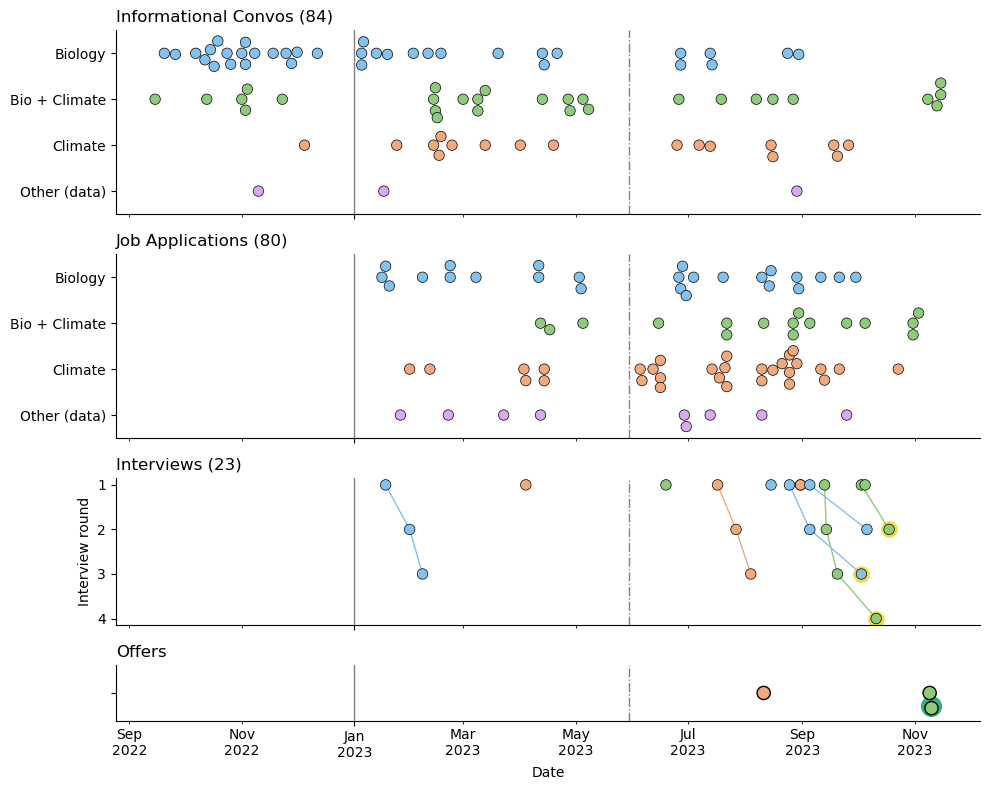

In [40]:
# Add interview lines
# swarm by sector?
yorder = ['Biology','Bio + Climate','Climate','Other (data)']
fig,(ax1,ax2,ax3,ax4) = plt.subplots(
    4,1,
    sharex=True,
    figsize=(10,8),
    gridspec_kw={'height_ratios': [2.5,2.5,2,0.75]}
)
msize=7.5
# info convos
sns.swarmplot(data=casual_df,x='Date',y='Sector2',hue='Sector2',palette=colors,
              order=yorder,legend=None,
              ax=ax1,size=msize,edgecolor='k',linewidth=0.5,)#color='#c5e8c3')

# job apps
sns.swarmplot(data=adf,x='Date',y='Sector2',hue='Sector2',palette=colors,
              order=yorder,legend=None,
              ax=ax2,size=msize,edgecolor='k',linewidth=0.5,color='#b1e1bc')

# interviews
for k,subdf in interview_df.groupby("company_id"):
    sns.lineplot(data=subdf,x='Date',y="Type",ax=ax3,
                 linewidth=1,legend=None,hue="Sector2",palette=colors)#color='k')
sns.scatterplot(data=interview_df,x='Date',y="Type",ax=ax3,
                s=msize+50,linewidth=0.5,edgecolor='k',
                hue="Sector2",palette=colors,#{'1':'#9bd8bb','2':'#6ac2ca','3':'#51b2cd','4':'#3d9fc7'},
                legend=None,zorder=2)
    
# offers
sns.swarmplot(data=odf,x='Date',ax=ax4,size=msize+2,hue='Sector2',
              linewidth=1,edgecolor='k',palette=colors,#{True:'#1675b1',False:'#b3b3b3'}
              legend=None)


locator = mdates.MonthLocator(bymonth=[3,5,7,9,11])
ax4.xaxis.set_minor_locator(locator)
#ax.xaxis.set_minor_formatter(mdates.ConciseDateFormatter(locator))
ax4.xaxis.set_minor_formatter(mdates.DateFormatter('%b\n%Y'))
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax1.set_title(f"Informational Convos ({casual_df.shape[0]})",loc='left')
ax1.set_ylabel("")
ax2.set_title(f"Job Applications ({adf.shape[0]})",loc='left')
ax2.set_ylabel("")
ax3.set_title(f"Interviews ({interview_df.shape[0]})",loc='left')
ax3.set_ylabel("Interview round")
ax4.set_title(f"Offers",loc='left')

# mark defense and 2023
defense = pd.to_datetime('2023-05-30')
y2023 = pd.to_datetime('2023-01-01')
for ax in [ax1,ax2,ax3,ax4]:
    ax.axvline(defense,color='gray',linestyle='-.',linewidth=1)
    ax.axvline(y2023,color='gray',linewidth=1)
    
# highlight job talks
jts = interview_df[interview_df['Job talk?']==True]
ax3.scatter(jts['Date'],jts['Type'],color='#F3DC44',s=120,)#'#feb928'

# highlight accept - finding the offset didn't work, just manually set it
acc = odf[odf['Accept']==True]
ax4.scatter(acc['Date'],-0.0049,color=sns.husl_palette(12)[5],s=200,) # #cadb20 #6abf50 #26bce1
ax4.set_ylim(-0.01,0.01)

    
sns.despine(left=False,bottom=False,top=True)
plt.tight_layout()
plt.savefig('img/convos_interviews_lines_sector_color.png')

### Considered a ternary plot, but stuck with simple triangle

In [41]:
cdf['Biology'] = cdf['Sector'].apply(lambda x: 1 if "B" in x else 0)
cdf['Climate'] = cdf['Sector'].apply(lambda x: 1 if "C" in x else 0)
cdf['DataScience'] = cdf['Sector'].apply(lambda x: 1 if "D" in x else 0)

cdf

Type       Date Sector Location  Job talk?  company_id        Sector2  \
0       0 2022-09-15    BCD        E      False           0  Bio + Climate   
1       0 2022-09-20     BD        M      False           1        Biology   
2       0 2022-09-26     BD        M      False           1        Biology   
3       0 2022-10-07     BD        M      False           2        Biology   
4       0 2022-10-12     BD        Z      False           1        Biology   
..    ...        ...    ...      ...        ...         ...            ...   
102     2 2023-10-18    BCD        Z       True           0  Bio + Climate   
103     0 2023-11-08     BC        Z      False          56  Bio + Climate   
104     0 2023-11-13    BCD        Z      False          34  Bio + Climate   
105     0 2023-11-15    BCD        M      False           0  Bio + Climate   
106     0 2023-11-15    BCD        Z      False          34  Bio + Climate   

     Biology  Climate  DataScience  
0          1        1            1  
1          1        0            1  
2          1        0            1  
3          1        0            1  
4          1        0            1  
..       ...      ...          ...  
102        1        1            1  
103        1        1            0  
104        1        1            1  
105        1        1            1  
106        1        1            1  

[107 rows x 10 columns]

In [42]:
# combine convo and app dfs
cadf = pd.concat([adf[['Sector','Sector2','Type','Date']],cdf[['Sector','Sector2','Type','Date']]])
cadf

Sector        Sector2  Type       Date
0       BD        Biology    -1 2023-01-16
1       BD        Biology    -1 2023-01-18
2       BD        Biology    -1 2023-01-20
3        D   Other (data)    -1 2023-01-26
4       CD        Climate    -1 2023-01-31
..     ...            ...   ...        ...
102    BCD  Bio + Climate     2 2023-10-18
103     BC  Bio + Climate     0 2023-11-08
104    BCD  Bio + Climate     0 2023-11-13
105    BCD  Bio + Climate     0 2023-11-15
106    BCD  Bio + Climate     0 2023-11-15

[187 rows x 4 columns]

In [43]:
xpos = {
    "B":1,
    "C":3,
    "D":5,
    "BC":2,
    "CD":4,
    "BD":6,
    "BCD":3.5
}

sector_df = cadf.groupby("Sector").size()
sector_df = sector_df.reset_index().rename(columns={0:"count"})
sector_df['x'] = sector_df['Sector'].apply(lambda x: xpos[x])
sector_df['y'] = sector_df['Sector'].apply(lambda x: len(x)*2)
sector_df['label'] = [
    'Biology',
    'Biology +\nClimate',
    'Biology +\nClimate + \nData Science',
    'Biology +\nData Science',
    'Climate',
    'Climate +\nData \nScience',
    'Data \nScience'
]
sector_df

Sector  count    x  y                                label
0      B      1  1.0  2                              Biology
1     BC      8  2.0  4                   Biology +\nClimate
2    BCD     45  3.5  6  Biology +\nClimate + \nData Science
3     BD     69  6.0  4              Biology +\nData Science
4      C      4  3.0  2                              Climate
5     CD     48  4.0  4            Climate +\nData \nScience
6      D     12  5.0  2                       Data \nScience

### Reposition into the triangle I want


In [44]:
xpos = {
    "B":1,
    "C":3,
    "D":5,
    "BC":1.7,
    "CD":4.5,
    "BD":3,
    "BCD":3
}
ypos = {
    "B":2.5,
    "C":6,
    "D":2.5,
    "BC":4.5,
    "CD":4.5,
    "BD":2.5,
    "BCD":4.4
}

sector_df = cadf.groupby("Sector").size()
sector_df = sector_df.reset_index().rename(columns={0:"count"})
sector_df['x'] = sector_df['Sector'].apply(lambda x: xpos[x])
sector_df['y'] = sector_df['Sector'].apply(lambda x: ypos[x])
sector_df['label'] = [
    'Biology',
    'Biology +\nClimate',
    'Biology +\nClimate + \nData Science',
    'Biology +\nData Science',
    'Climate',
    'Climate +\nData \nScience',
    'Data \nScience'
]
sector_df

Sector  count    x    y                                label
0      B      1  1.0  2.5                              Biology
1     BC      8  1.7  4.5                   Biology +\nClimate
2    BCD     45  3.0  4.4  Biology +\nClimate + \nData Science
3     BD     69  3.0  2.5              Biology +\nData Science
4      C      4  3.0  6.0                              Climate
5     CD     48  4.5  4.5            Climate +\nData \nScience
6      D     12  5.0  2.5                       Data \nScience

In [45]:
order=['B','C','D','BD','BC','CD','BCD']
sector_df['sector_order']=pd.Categorical(sector_df['Sector'], order)
sector_df = sector_df.sort_values("sector_order")

more_colors = {
    'B':lighter_husl4[5], # light orange?
    'C':lighter_husl4[1], # light orange?
    'D':lighter_husl4[10], # dark blue
    'BC':'#F3DC44',#lighter_husl4[3],
    'CD':lighter_husl4[12],
    'BD':lighter_husl4[9],
    'BCD':sns.husl_palette(12)[5],
}

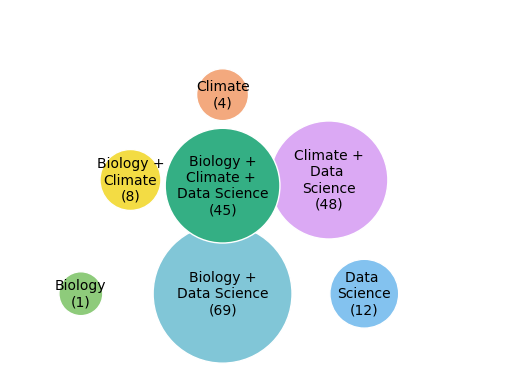

In [46]:

ax = sns.scatterplot(data=sector_df,
                     x='x',y='y',size='count',sizes=(1000,10000),legend=None,
                    palette=more_colors,hue='Sector',linewidth=1,zorder=True)

for x,y,txt,c in sector_df[['x','y','label','count']].values:
    label=f"{txt}\n({c})"
    ax.text(x,y,label,horizontalalignment='center',verticalalignment='center')
    
plt.ylim(1,7.5)
plt.xlim(0,7)
sns.despine(bottom=True,left=True)
ax.set(xticklabels=[],yticklabels=[])  # remove the tick labels
ax.tick_params(bottom=False,left=False)
plt.xlabel("")
plt.ylabel("")
plt.savefig('img/convo_app_focus.png',dpi=300)

### Attempts to make a stream graph with temporal context

In [47]:
# group sector counts by month/year
gbm = cadf.groupby(cadf['Date'].dt.strftime('%B %Y'))['Sector2'].value_counts().rename('count').reset_index()
gbm["Date"] = pd.to_datetime(gbm['Date'])
gbm.head(10)

Date        Sector2  count
0 2023-04-01        Climate      7
1 2023-04-01  Bio + Climate      5
2 2023-04-01        Biology      5
3 2023-04-01   Other (data)      1
4 2023-08-01        Climate     13
5 2023-08-01        Biology      9
6 2023-08-01  Bio + Climate      8
7 2023-08-01   Other (data)      2
8 2022-12-01        Biology      2
9 2022-12-01        Climate      1

In [48]:
#gbm["Date"].astype('')

In [49]:
# S&P 500 data from 2023
#https://www.nasdaq.com/market-activity/index/spx/historical?page=1&rows_per_page=10&timeline=y5
sp500 = pd.read_csv('data/sp500_2023.csv')
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500

Date  Close/Last     Open     High      Low
0   2023-11-30     4567.80  4554.87  4569.89  4537.24
1   2023-11-29     4550.58  4571.84  4587.64  4547.15
2   2023-11-28     4554.89  4545.55  4568.14  4540.51
3   2023-11-27     4550.43  4554.86  4560.52  4546.32
4   2023-11-24     4559.34  4555.84  4560.31  4552.80
..         ...         ...      ...      ...      ...
332 2022-08-05     4145.19  4115.87  4151.58  4107.31
333 2022-08-04     4151.94  4154.85  4161.29  4135.42
334 2022-08-03     4155.17  4107.96  4167.66  4107.96
335 2022-08-02     4091.19  4104.21  4140.47  4079.81
336 2022-08-01     4118.63  4112.38  4144.95  4096.02

[337 rows x 5 columns]

In [50]:
stream = alt.Chart(gbm,title="Focus: Sum of energy spent on conversations and applications").mark_area().encode(
    alt.X('Date:T').axis(format='%b %Y', domain=False, tickSize=4,tickMinStep=1),
    alt.Y('count:Q',).stack('center').axis(None),
    alt.Color('Sector2:N',title='Sector',).scale(scheme='viridis')
).properties(
    width=500,
)

lines = alt.Chart(sp500).mark_line(color='#AF3DEA').encode(
    x='Date',
    y=alt.Y('High',title="S&P 500",axis=alt.Axis(orient='right'),scale=alt.Scale(domain=[3500,5000]))
)

# alt.vconcat(stream,lines).configure_axis(
#     labelFontSize=10
# ).configure_legend(
#     titleFontSize=16,
#     labelFontSize=14,
#     orient='top-left'
# ).configure_title(
#     fontSize=18
# ).interactive()

chart = stream+lines
chart.resolve_scale(y='independent').configure_axis(
    labelFontSize=10
).configure_legend(
    titleFontSize=16,
    labelFontSize=14,
    orient='top-left'
).configure_title(
    fontSize=18
)

alt.LayerChart(...)

In [51]:
# Look at type of job hunt effort over time

cadf['Type'].value_counts()
def set_type(t):
    if t==-1:
        return "Job app"
    elif t==0:
        return "Casual convo"
    elif t>0:
        return "Interview"
    else:
        raise ValueError(f"unknown data type {t}.")
        
cadf['Type2'] = cadf['Type'].apply(lambda x: set_type(x))

type_order = ['Casual convo','Job app','Interview']

type_over_time = cadf.groupby(cadf['Date'].dt.strftime('%B %Y'))['Type2'].value_counts().rename('count').reset_index()
type_over_time["Date"] = pd.to_datetime(type_over_time['Date'])
type_over_time["Type_order"] = pd.Categorical(type_over_time['Type2'], type_order,ordered=True)
type_over_time = type_over_time.sort_values('Type_order')
type_over_time

Date         Type2  count    Type_order
32 2023-09-01  Casual convo      3  Casual convo
14 2023-07-01  Casual convo      5  Casual convo
22 2023-05-01  Casual convo      2  Casual convo
23 2022-11-01  Casual convo     12  Casual convo
24 2023-11-01  Casual convo      4  Casual convo
10 2023-01-01  Casual convo      7  Casual convo
17 2023-06-01  Casual convo      4  Casual convo
26 2022-10-01  Casual convo      8  Casual convo
19 2023-03-01  Casual convo      6  Casual convo
6  2022-12-01  Casual convo      3  Casual convo
4  2023-08-01  Casual convo      8  Casual convo
29 2022-09-01  Casual convo      3  Casual convo
1  2023-04-01  Casual convo      8  Casual convo
7  2023-02-01  Casual convo     11  Casual convo
28 2023-10-01       Job app      4       Job app
30 2023-09-01       Job app      9       Job app
21 2023-05-01       Job app      3       Job app
20 2023-03-01       Job app      2       Job app
25 2023-11-01       Job app      1       Job app
0  2023-04-01       Job app      9       Job app
13 2023-07-01       Job app     10       Job app
11 2023-01-01       Job app      5       Job app
8  2023-02-01       Job app      5       Job app
3  2023-08-01       Job app     19       Job app
16 2023-06-01       Job app     13       Job app
31 2023-09-01     Interview      5     Interview
15 2023-07-01     Interview      2     Interview
12 2023-01-01     Interview      2     Interview
9  2023-02-01     Interview      1     Interview
27 2023-10-01     Interview      6     Interview
5  2023-08-01     Interview      5     Interview
2  2023-04-01     Interview      1     Interview
18 2023-06-01     Interview      1     Interview

In [52]:
# Some notably large layoffs in early 2023

# https://techcrunch.com/2024/03/01/tech-layoffs-2023-list/
# amazon - Jan 5, 2023 (18000)
# microsoft - Jan 18, 2023 (10000)
# Alphabet - Jan 21, 2023 (12000)
# meta - March 14, 2023 (10000)
# amazon - March 20, (9000)
# meta - May 24, 2023 (6000)

layoffs = pd.DataFrame(
    data=[['Amazon','2023-01-05',18000,4900],
     ['Microsoft','2023-01-18',10000,4800],
     ['Alphabet','2023-01-21',12000,4700],
     ['Meta','2023-03-14',10000,4700]],
    columns=['Company','Date','count','yoffset']
)
layoffs['Date'] = pd.to_datetime(layoffs['Date'])
layoffs

Company       Date  count  yoffset
0     Amazon 2023-01-05  18000     4900
1  Microsoft 2023-01-18  10000     4800
2   Alphabet 2023-01-21  12000     4700
3       Meta 2023-03-14  10000     4700

In [57]:
stream = alt.Chart(type_over_time,title="Job hunting in 2023").transform_joinaggregate(
    order='sum(count)',
    groupby=['Type2']
).mark_area().encode(
    x=alt.X('Date:T').axis(format='%b %Y',),
    y=alt.Y('count:Q',title="Count of job hunt interactions"),#.stack('center')#.axis(None),
    color=alt.Color('Type2:N',title='Interaction Type',sort=type_order).scale(scheme='viridis'),
    order=alt.Order('order:Q',sort='descending')#'Type_order:O'
).properties(
    width=600,
)

lines = alt.Chart(sp500).mark_line(color='#632de9',opacity=0.6).encode(
    x=alt.X('Date').axis(format='%b %Y', domain=False, ),
    y=alt.Y('High',title="S&P 500",axis=alt.Axis(orient='right'),scale=alt.Scale(domain=[3500,5000]))
).properties(
    width=600
)

cuts = alt.Chart(layoffs).mark_rule().encode(
    x='Date:T',
    color=alt.Color('Company:N').scale(scheme='tableau10').legend(None)
).properties(
    width=600
)
co = alt.Chart(layoffs).mark_text(align='left').encode(
    x='Date:T',
    y='yoffset:Q',
    text=alt.Text('Company:N'),
    color=alt.Color('Company:N').scale(scheme='tableau10').legend(None),
).properties(
    width=600
)
layoff_label = alt.Chart().mark_text(color='black',size=14).encode(
    x=alt.value(298),
    y=alt.value(20),
    text=alt.value("Big Tech Layoffs")
)
acc = pd.DataFrame([['2023-11-15',3800]],columns=['Date','yoffset'])
acc1 = alt.Chart(acc).mark_rule(color='#5dc963',size=2).encode(
    x="Date:T",
)
acc2 = alt.Chart(acc).mark_text(color='#5dc963',angle=270,xOffset=-7).encode(
    x="Date:T",
    y='yoffset:Q',
    text=alt.value("Accepted offer"),
)

sp = lines+cuts+co+acc1+acc2+layoff_label

chart = stream+sp
chart = chart.resolve_scale(
    y='independent',#x='shared'
    color='independent'
).configure_axis(
    labelFontSize=10,
    titleFontSize=14,
    grid=False
).configure_legend(
    titleFontSize=16,
    labelFontSize=14,
    orient='top-left'
).configure_title(
    fontSize=18
).configure_axisRight(
  labelColor='#632de9',
  titleColor='#632de9'
)
chart

alt.LayerChart(...)

### try job hunt efforts as cumulative dots instead

In [56]:
dots = alt.Chart(
    type_over_time, width=600,
    title='Job hunting in 2023'
).mark_circle(size=500).transform_joinaggregate(
    order='sum(count)',
    groupby=['Type2']
).transform_window(
    # Sort the data chronologically
    sort=[{'field': 'Date'}],
    # Include all previous records before the current record and none after
    # (This is the default value so you could skip it and it would still work.)
    frame=[None, 0],
    groupby=['Type2'],
    # What to add up as you go
    cumulative_line='sum(count)'
).encode(
    x='Date:T',
    # Plot the calculated field created by the transformation
    y=alt.Y('cumulative_line:Q',title='Cumulative count'),
    color=alt.Color("Type2",sort=type_order,title="Interaction Type").scale(scheme='viridis'),
    
)
dotsp = dots + sp
dotsp.resolve_scale(y='independent',color='independent'
).configure_axis(
    labelFontSize=10,
    titleFontSize=14,
    grid=False
).configure_legend(
    titleFontSize=16,
    labelFontSize=14,
    orient='top-left'
).configure_title(
    fontSize=18
).configure_axisRight(
  labelColor='#632de9',
  titleColor='#632de9'
)

alt.LayerChart(...)

In [58]:
dots = alt.Chart(
    cadf, width=600,
    title='Job hunting in 2023'
).mark_circle(size=50).transform_joinaggregate(
    order='count(Type2)',
    groupby=['Type2']
).transform_window(
    # Sort the data chronologically
    sort=[{'field': 'Date'}],
    # Include all previous records before the current record and none after
    # (This is the default value so you could skip it and it would still work.)
    frame=[None, 0],
    groupby=['Type2'],
    # What to add up as you go
    cumulative_line='count(Type2)'
).encode(
    x='Date:T',
    # Plot the calculated field created by the transformation
    y=alt.Y('cumulative_line:Q',title='Cumulative count'),
    color=alt.Color("Type2",sort=type_order,title="Interaction Type").scale(scheme='viridis'),
    
)
dotsp = dots + sp
chart = dotsp.resolve_scale(y='independent',color='independent'
).configure_axis(
    labelFontSize=10,
    titleFontSize=14,
    grid=False
).configure_legend(
    titleFontSize=16,
    labelFontSize=14,
    orient='top-left'
).configure_title(
    fontSize=18
).configure_axisRight(
  labelColor='#632de9',
  titleColor='#632de9'
)
chart.save('img/job_hunting_sp_layoffs.html')
chart

alt.LayerChart(...)

# Scratch

In [47]:
# attempt export to chart studio for easy sharing online?
import chart_studio
import chart_studio.plotly as py

# username='erinhwilson'
# api_key='' # paste
# chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [136]:
# exporting to chart studio does not preserve the style/alignment in the fig... >.< 
# py.plot(fig, filename="sankey_job", auto_open = True)


Trying to adjust the positions of nodes so it looks better in chart studio export (it's not exactly the same when exported), but it's not consistent and I gave up

In [137]:
fig = go.Figure(go.Sankey(
    #arrangement = "snap",
    node = {
        "label": node_sort,
        "color":[node_color[node_map[x]] for x in node_sort],
        'hovertemplate':'%{value:1f}<extra></extra>',
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk','Terminated',
# 'No','Yes','Unknown']

        "x": [0.01, 
              0.1, 0.1, 
              0.2, 0.2, 0.2, 0.2,
              0.27, 
              0.34, 0.43, 0.38,
              0.5, 0.5, 0.5,],
        "y": [0.75, 
              0.36, 1.15, 
              1.15, 0.6, 0.3, 0.1,
              0.1, 
              0.125, 0.1, 0.01,
              0.87, 0.15, 0.01,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values,
        'hovertemplate':'%{source.label} --> %{target.label}: %{value:1f}<extra></extra>',
    },
    orientation = 'v',
    ),
    layout = go.Layout(
        autosize=True,
        width=800,
        height=600,
    ))
fig.show()

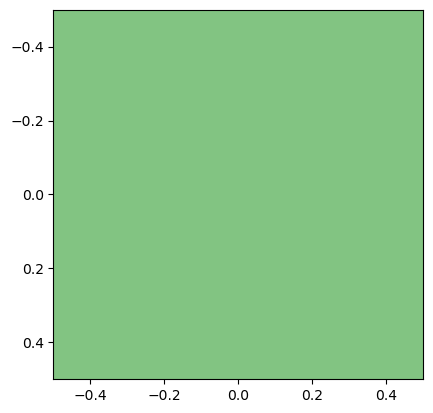

In [50]:
# check rgba value
val = [0.020,0.545,0.020,0.5]
plt.imshow([[val]])

In [51]:
sdf[sdf['source']=="Cold Applied"][['source','target','target_color']].values

array([['Cold Applied', 'Lost to the Abyss',
        'rgba(0.996,0.710,0.494,0.5)'],
       ['Cold Applied', 'Automated Reject',
        'rgba(0.996,0.529,0.663,0.5)'],
       ['Cold Applied', 'Interview Request',
        'rgba(0.318,0.686,0.961,0.5)']], dtype=object)

In [138]:
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": node_labels,
        "color":[node_color[node_map[x]] for x in node_sort],
# 'Job App',
# 'Personal Contact','Cold Applied',
# 'Abyss','Automated Reject','Human Reject','Interview',
# 'Screen','Meet Team','Job Talk','Terminated',
# 'No','Yes','Unknown']

#         "x": [0.0, 
#               0.1, 0.1, 
#               0.2, 0.2, 0.2, 0.2,
#               0.25, 
#               0.3, 0.4, 0.35,
#               0.5, 0.5, 0.5,],
#         "y": [0, 
#               0.55, 1.85, 
#               1.9, 1.0, 0.55, 0.2,
#               0.2, 0.2, 0.2, -0.01,
#               1.4, 0.2, -0.01,],
        'pad':10},  # 10 Pixels
    link = {
        "source": sdf['source_idx'].values,
        "target": sdf['target_idx'].values,
        "value": sdf['count'].values,
        "color": sdf["target_color"].values
    },
    orientation = 'v',
),
)

fig.show()

In [139]:
# import holoviews as hv
# from holoviews import opts, dim
# hv.extension('bokeh')

# sankey = hv.Sankey(sdf)
# sankey.opts(width=600, height=400,node_sort=False,edge_color='target',)

In [56]:
sankey = hv.Sankey([
    ['A', 'X', 5],
    ['A', 'Y', 7],
    ['A', 'Z', 6],
    ['B', 'X', 2],
    ['B', 'Y', 9],
    ['B', 'Z', 4],
    ['Z', 'J', 3],
]
)
sankey.opts(width=600, height=400)

:Sankey   [start,end]   (Value)